# Here, we decide to learn tensorflow from a simple example directly!

## General writing flow
1. import required libraries
2. load data and do some data pre-processing
3. split your data into training and validation set
4. build the network
5. train the model and record/monitoring the performance

## 1. Import required libries and set some parameters 

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# setting hyperparameter
batch_size = 32
epochs = 200
lr = 0.01
train_ratio = 0.9

## 2. Load data and do some pre-processing
We use MNIST HERE (with sklearn 8x8 version rather than use tensorflow 28x28 version)

In [3]:
from sklearn.datasets import load_digits

digits = load_digits()
x_, y_ = digits.data, digits.target

In [4]:
x_

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [5]:
# min-max normalization
x_ = x_ / x_.max() 

# one hot encoding
y_one_hot = np.zeros((len(y_), 10))  
y_one_hot[np.arange(len(y_)), y_] = 1

In [7]:
x_

array([[0.    , 0.    , 0.3125, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.625 , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 1.    , 0.5625, 0.    ],
       ...,
       [0.    , 0.    , 0.0625, ..., 0.375 , 0.    , 0.    ],
       [0.    , 0.    , 0.125 , ..., 0.75  , 0.    , 0.    ],
       [0.    , 0.    , 0.625 , ..., 0.75  , 0.0625, 0.    ]])

In [8]:
y_one_hot

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

## 3. Split your data into training and validation sets

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x_, 
                                                    y_one_hot, 
                                                    test_size=0.05, 
                                                    stratify=y_)

x_train, x_valid, y_train, y_valid = train_test_split(x_train, 
                                                      y_train, 
                                                      test_size=1.0 - train_ratio,
                                                      stratify=y_train.argmax(axis=1))

print("training set data dimension")
print(x_train.shape)
print(y_train.shape)
print("-----------")
print("training set: {}".format(len(x_train)))
print("validation set: {}".format(len(x_valid)))
print("testing set: {}".format(len(x_test)))

training set data dimension
(1536, 64)
(1536, 10)
-----------
training set: 1536
validation set: 171
testing set: 90


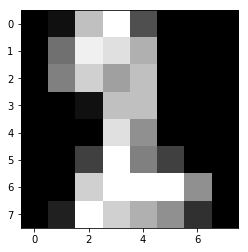

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [27]:
plt.imshow(x_train[0].reshape(8, 8), cmap='gray')
plt.show()
print(y_train[0])

## 4a.Build the network with low-level tensor elements

![title](pics/ex4-1.PNG)

### _What we want to train are those lines(weights), not those neurons._

In [28]:
# build the graph
tf.reset_default_graph()

with tf.name_scope('input'):
    x_input = tf.placeholder(shape=(None, 64), name='x_input', dtype=tf.float32)
    y_out = tf.placeholder(shape=(None, 10), name='y_label', dtype=tf.float32)

with tf.variable_scope('hidden_layer'):
    w1 = tf.Variable(tf.truncated_normal(shape=[64, 25], stddev=0.1),
                     name='weight1',
                     dtype=tf.float32)
    b1 = tf.Variable(tf.constant(0.0, shape=[25]),
                     name='bias1', 
                     dtype=tf.float32)
    z1 = tf.add(tf.matmul(x_input, w1), b1)  # (None, 64)×(64, 25)+(None, 25) = (None, 25)
    a1 = tf.nn.relu(z1, name='h1_out')
    
with tf.variable_scope('output_layer'):
    w2 = tf.Variable(tf.truncated_normal(shape=[25, 10], stddev=0.1),
                     name='weight2',
                     dtype=tf.float32)
    b2 = tf.Variable(tf.constant(0.0, shape=[10]),
                     name='bias2', 
                     dtype=tf.float32)
    output = tf.add(tf.matmul(a1, w2), b2, name='output')

with tf.name_scope('cross_entropy'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=y_out), name='loss')
    
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(output), 1), tf.argmax(y_out, 1)) 
    compute_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 

with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss)

In [29]:
tf.global_variables()

[<tf.Variable 'hidden_layer/weight1:0' shape=(64, 25) dtype=float32_ref>,
 <tf.Variable 'hidden_layer/bias1:0' shape=(25,) dtype=float32_ref>,
 <tf.Variable 'output_layer/weight2:0' shape=(25, 10) dtype=float32_ref>,
 <tf.Variable 'output_layer/bias2:0' shape=(10,) dtype=float32_ref>]

In [30]:
loss

<tf.Tensor 'cross_entropy/loss:0' shape=() dtype=float32>

## 5a.Train the model and record the performance

In [31]:
# create a session and train the model
train_loss_epoch, valid_loss_epoch = [], []
train_acc_epoch, valid_acc_epoch = [], []

sess = tf.Session()
    
sess.run(tf.global_variables_initializer())

for i in tqdm_notebook(range(epochs)):

    total_batch = len(x_train) // batch_size 
    train_loss_batch, train_acc_batch = [], []

#     training
    for j in range(total_batch):

        batch_idx_start = j * batch_size
        batch_idx_stop = (j+1) * batch_size

        x_batch = x_train[batch_idx_start : batch_idx_stop]  # xbatch = xtrain[0:32], xbatch = xtrain[32:64], and so on...
        y_batch = y_train[batch_idx_start : batch_idx_stop]

        batch_loss, batch_acc, _ = sess.run([loss, compute_acc, train_step], 
                                            feed_dict={x_input: x_batch, y_out: y_batch})

        train_loss_batch.append(batch_loss) 
        train_acc_batch.append(batch_acc)  

#     validation
    valid_acc, valid_loss = sess.run([compute_acc, loss],
                                     feed_dict={x_input: x_valid, y_out : y_valid})
    
#     collect loss and accuracy
    train_loss_epoch.append(np.mean(train_loss_batch)) 
    train_acc_epoch.append(np.mean(train_acc_batch))
    valid_loss_epoch.append(valid_loss) 
    valid_acc_epoch.append(valid_acc) 

    x_train, y_train = shuffle(x_train, y_train)
    
print('--- training done ---')


--- training done ---


In [32]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

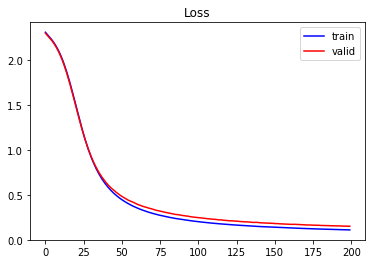

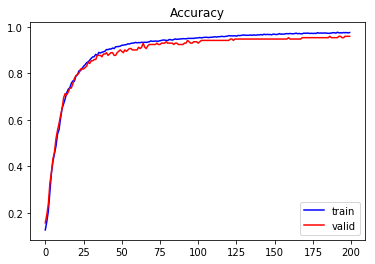

In [10]:
# plot
plt.plot(train_loss_epoch, 'b', label='train')
plt.plot(valid_loss_epoch, 'r', label='valid')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(train_acc_epoch, 'b', label='train')
plt.plot(valid_acc_epoch, 'r', label='valid')
plt.legend(loc=4)
plt.title("Accuracy")
plt.show()

In [11]:
test_acc, test_loss = sess.run([compute_acc, loss],
                                feed_dict = {x_input: x_test, y_out : y_test})

print('testing accuracy: {:.2f}'.format(test_acc))

sess.close()

testing accuracy: 1.00


## 4b. Build the network with "layer" 

In [12]:
tf.reset_default_graph() 

with tf.name_scope('input'):
    x_input = tf.placeholder(shape=(None, 64), 
                             name='x_input',
                             dtype=tf.float32)
    y_out = tf.placeholder(shape=(None, 10), 
                           name='y_label',
                           dtype=tf.float32)

with tf.variable_scope('hidden_layer'):
    x_h1 = tf.layers.dense(inputs=x_input, units=25, activation=tf.nn.relu)

with tf.variable_scope('output_layer'):
    output = tf.layers.dense(x_h1, 10, name='output')

with tf.name_scope('cross_entropy'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=y_out), name='loss')
    
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(output), 1), tf.argmax(y_out, 1))
    compute_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss)

In [13]:
tf.global_variables()

[<tf.Variable 'hidden_layer/dense/kernel:0' shape=(64, 25) dtype=float32_ref>,
 <tf.Variable 'hidden_layer/dense/bias:0' shape=(25,) dtype=float32_ref>,
 <tf.Variable 'output_layer/output/kernel:0' shape=(25, 10) dtype=float32_ref>,
 <tf.Variable 'output_layer/output/bias:0' shape=(10,) dtype=float32_ref>]

## 5b.Train the model and record the performance

In [14]:
# create a session and train the model
train_loss_epoch, valid_loss_epoch = [], []
train_acc_epoch, valid_acc_epoch = [], []

sess = tf.Session()
    
sess.run(tf.global_variables_initializer())

for i in tqdm_notebook(range(epochs)):

    total_batch = len(x_train) // batch_size 
    train_loss_in_batch, train_acc_in_batch = [], []

    for j in range(total_batch):

        batch_idx_start = j * batch_size
        batch_idx_stop = (j+1) * batch_size

        x_batch = x_train[batch_idx_start : batch_idx_stop] 
        y_batch = y_train[batch_idx_start : batch_idx_stop]

        this_loss, this_acc, _ = sess.run([loss, compute_acc, train_step], 
                                          feed_dict={x_input: x_batch, y_out: y_batch})

        train_loss_in_batch.append(this_loss) 
        train_acc_in_batch.append(this_acc)  


    valid_acc, valid_loss = sess.run([compute_acc, loss],
                                     feed_dict={x_input: x_valid, y_out : y_valid})
    
    valid_loss_epoch.append(valid_loss) 
    valid_acc_epoch.append(valid_acc)   
    train_loss_epoch.append(np.mean(train_loss_in_batch)) 
    train_acc_epoch.append(np.mean(train_acc_in_batch))  

    x_train, y_train = shuffle(x_train, y_train)


print('--- training done ---')


--- training done ---


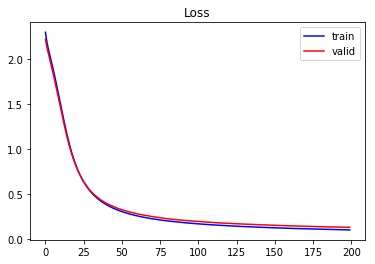

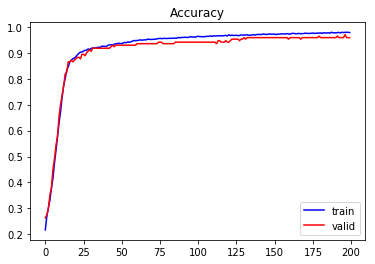

In [15]:
# plot
plt.plot(train_loss_epoch, 'b', label='train')
plt.plot(valid_loss_epoch, 'r', label='valid')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(train_acc_epoch, 'b', label='train')
plt.plot(valid_acc_epoch, 'r', label='valid')
plt.legend(loc=4)
plt.title("Accuracy")
plt.show()

In [16]:
test_acc, test_loss = sess.run([compute_acc, loss],
                                feed_dict={x_input: x_test, y_out : y_test})

print('testing accuracy: {:.2f}'.format(test_acc))

sess.close()

testing accuracy: 1.00


# Practice
Build a neural network with 3 hidden layers.

![title](pics/ex4-2.PNG)